In [1]:
import sqlite3
import pandas as pd
from IPython.display import display

# Connect to sqlite database and get all truthed roadways with no obscuration that are valid
with sqlite3.connect('file:/data/road_surface_classifier/features.sqlite3?mode=ro', uri=True) as con:
    cursor = con.cursor()
    cursor.execute("""
        SELECT osm_id, chip_path from features
        WHERE obscuration = 2 AND no_data = 0 and bad_detect = 0;
    """)
    rows = cursor.fetchall()

# Put this all in a dataframe
df = pd.DataFrame(rows, columns=['osm_id', 'chip_path']).set_index('osm_id')

# Load OSM features and extract WKT values for the OSM IDs from above
osm_df = pd.read_csv('/data/road_surface_classifier/features.csv')
osm_df = osm_df.set_index('osm_id').loc[df.index][['wkt', 'x', 'y']]

# Combine this with our original DataFrame to get a "super-duper" DataFrame with wkt values
df = pd.concat([df, osm_df], axis=1)
display(df)

,chip_path,wkt,x,y
osm_id,,,,
210888433,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-78.1103235 39.1647521,-78.111063 ...",37094.207031,50014.601562
210764643,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-78.5991161 35.8970177,-78.5991363...",36918.113281,51514.984375
210764626,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-78.5942261 35.8575052,-78.5941042...",36921.093750,51532.328125
210764636,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-78.6051821 35.8923863,-78.6052984...",36913.605469,51519.058594
210942210,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-82.523946 31.8573695,-82.5244702 ...",35480.445312,53285.148438
...,...,...,...,...
429453599,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-79.5930489 35.1699594,-79.5934465...",36553.347656,51841.335938
672546920,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-79.2248212 35.9200611,-79.2247062...",36691.058594,51506.300781
674584802,/home/jon/data/road_surface_classifier/rsc_nai...,"LINESTRING (-80.939776 33.7243325,-80.9398456 ...",36065.214844,52478.652344


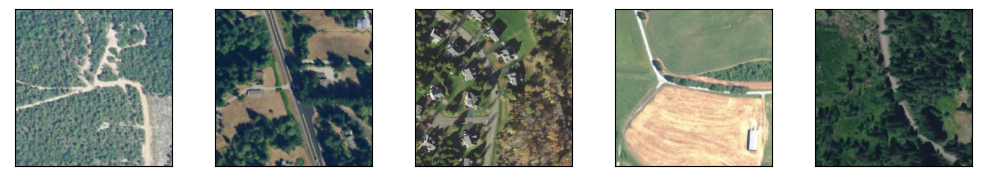

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

# Take a random sample
s = df.sample(n=5, random_state=1234)

# Plot the sample
fig, ax = plt.subplots(1, len(s), figsize=(10,3))
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
for idx, ax_ in enumerate(ax):
    im_path = s.iloc[idx]['chip_path']
    im = np.array(PIL.Image.open(im_path))
    ax_.imshow(im)
    ax_.get_xaxis().set_visible(False)
    ax_.get_yaxis().set_visible(False)

In [3]:
import skimage.color
import skimage.morphology

def get_obsc_mask(im, mask):
    im_lab = skimage.color.rgb2lab(im)
    avg_color_lab = np.median(im_lab[np.where(mask)], axis=0)
    diff = skimage.color.deltaE_cie76(avg_color_lab, im_lab)
    obsc_mask = skimage.morphology.remove_small_objects(diff < 25, 25)
    return obsc_mask

100%|██████████| 5/5 [00:00<00:00, 67.92it/s]


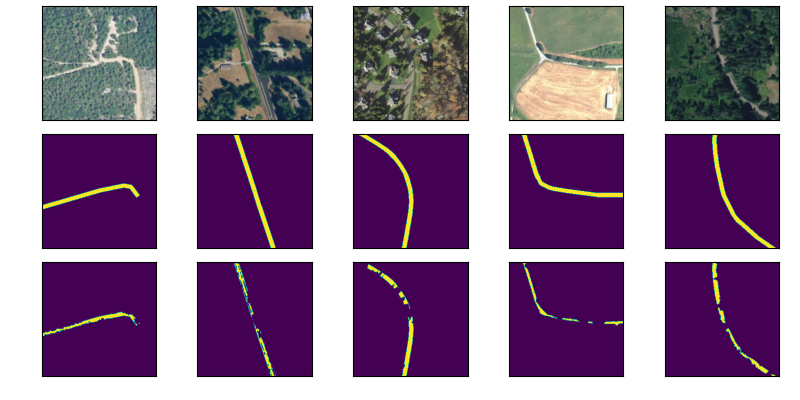

In [4]:
%matplotlib widget

from osgeo import ogr
ogr.UseExceptions()

from tqdm import tqdm

import PIL.Image
import PIL.ImageDraw

from data_prep.utils import wgs84_to_im

fig, ax = plt.subplots(3, len(s), sharex=True, sharey=True, figsize=(8, 4))
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
for ax_ in ax.flatten():  # type: ignore
    ax_.get_xaxis().set_visible(False)
    ax_.get_yaxis().set_visible(False)

for idx in tqdm(range(len(s))):

    row = s.iloc[idx]

    # Get list of points from WKT
    geom = ogr.CreateGeometryFromWkt(row['wkt'])
    pts = np.array(
        [geom.GetPoint_2D(idx) for idx in range(geom.GetPointCount())])
    lon_ar, lat_ar = pts[:, 0], pts[:, 1]

    # Convert to image-space x, y
    ix, iy = wgs84_to_im(lon_ar,
                            lat_ar,
                            row['x'],
                            row['y'],
                            z=17,
                            iw=256,
                            ih=256)

    # Load image
    im = np.array(PIL.Image.open(row['chip_path']))

    # Create a new image of the same shape, and draw a line
    # to create a mask
    mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint8)
    mask_pil = PIL.Image.new('L', ((im.shape[1], im.shape[0])), color=0)
    d = PIL.ImageDraw.Draw(mask_pil)
    d.line(
        [(x, y) for x, y in zip(ix, iy)],     # type: ignore
        fill=255,
        width=2, # Original: 10,
        joint="curve")
    mask = np.array(mask_pil)

    # Make obscuration mask
    obsc_mask = get_obsc_mask(im, mask)

    # Do the same thing, but make it thicc
    mask_thicc = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint8)
    mask_pil_thicc = PIL.Image.new('L', ((im.shape[1], im.shape[0])), color=0)
    d = PIL.ImageDraw.Draw(mask_pil_thicc)
    d.line(
        [(x, y) for x, y in zip(ix, iy)],     # type: ignore
        fill=255,
        width=10, # Original: 10,
        joint="curve")
    mask_thicc = np.array(mask_pil_thicc)

    ax[0][idx].imshow(im)
    ax[1][idx].imshow(mask_thicc)
    ax[2][idx].imshow(obsc_mask & mask_thicc)

plt.show()